In [2]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import numpy as np
from safetensors import safe_open
from scipy.stats import entropy
import torch

In [3]:
evo2_tensors = safe_open("tensors/roderic_evo2.safetensors", "pt")

In [4]:
evo2_probs = evo2_tensors.get_tensor("mystery_seq")

In [5]:
evo2_entropy = entropy(evo2_probs.to(torch.float32).numpy(), axis=1, base=2)

In [6]:
evo2_ic = 2 - evo2_entropy

In [7]:
evo2_ic_smooth = np.convolve(evo2_ic, [0.25, 0.5, 0.25], "same")

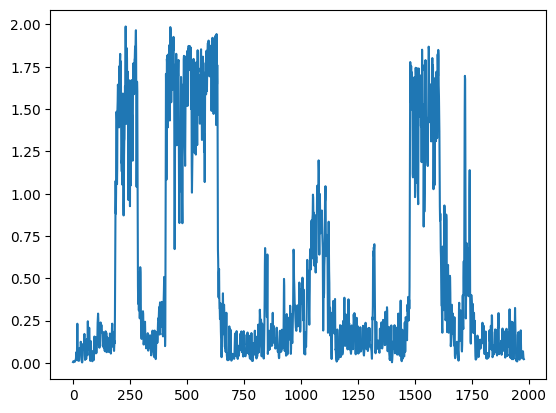

In [8]:
plt.plot(np.arange(0, len(evo2_ic_smooth), 1), evo2_ic_smooth)

In [9]:
def collapse_runs(arr):
    return np.column_stack((arr[np.r_[True, np.diff(arr) > 1]], arr[np.r_[np.diff(arr) > 1, True]]))

In [10]:
exon_idx = np.argwhere(evo2_ic_smooth > 0.5).flatten()
exon_ranges = collapse_runs(exon_idx)

In [11]:
evo2_exons = exon_ranges[exon_ranges[:,1] - exon_ranges[:,0] > 10]
evo2_exons

array([[ 185,  284],
       [ 406,  637],
       [1040, 1096],
       [1103, 1117],
       [1478, 1615]])

In [12]:
evo2_coords = [((a, -0.1), (b, -0.1)) for a,b in evo2_exons]
evo2_coords

[((np.int64(185), -0.1), (np.int64(284), -0.1)),
 ((np.int64(406), -0.1), (np.int64(637), -0.1)),
 ((np.int64(1040), -0.1), (np.int64(1096), -0.1)),
 ((np.int64(1103), -0.1), (np.int64(1117), -0.1)),
 ((np.int64(1478), -0.1), (np.int64(1615), -0.1))]

In [13]:
real_coords = [((187, -0.2), (278, -0.2)), ((409, -0.2), (631, -0.2)), ((1482, -0.2), (1610, -0.2))]

In [14]:
x = np.arange(0, len(evo2_ic_smooth), 1)

Text(0, 0.5, 'Smoothed information content')

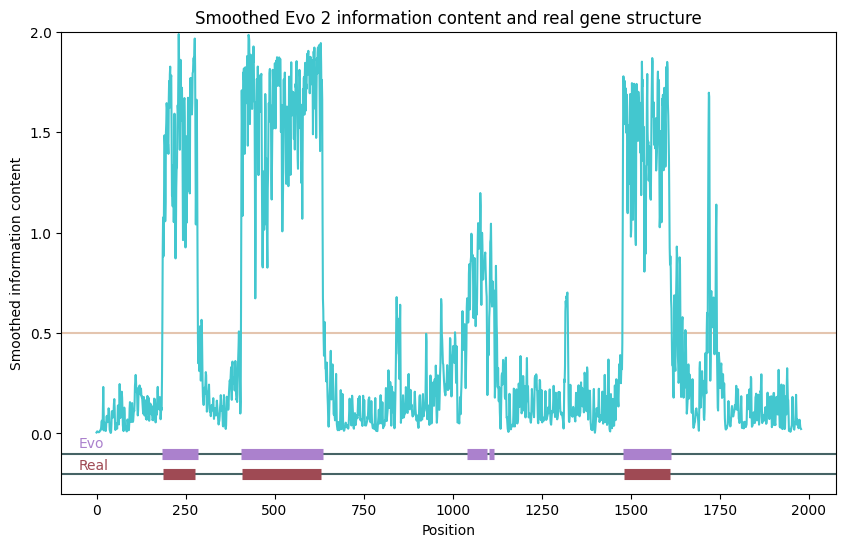

In [15]:
fig, (ax) = plt.subplots(1, figsize=(10,6))

plt.axhline(y=0.5, color="#e4c5af")
plt.plot(x, evo2_ic_smooth, color="#43c7cf")

plt.axhline(y=-0.1, color="#466365")
ax.add_collection(mc.LineCollection(evo2_coords, color="#ab81cd", linewidth=8))
ax.text(-50, -0.07, "Evo", color="#ab81cd")

plt.axhline(y=-0.2, color="#466365")
ax.add_collection(mc.LineCollection(real_coords, color="#9f4a54", linewidth=8))
ax.text(-50, -0.18, "Real", color="#9f4a54")

ax.set_ylim(-0.3, 2)

plt.title("Smoothed Evo 2 information content and real gene structure")
ax.set_xlabel("Position")
ax.set_ylabel("Smoothed information content")

In [16]:
def ranges_to_coords(ranges, y):
    return [((a, y), (b, y)) for a,b in ranges]

In [17]:
def get_ic(probs):
    return 2 - entropy(probs.to(torch.float32).numpy(), axis=1, base=2)

In [22]:
def get_llm_exons(probs, conv_filter=[0.25, 0.5, 0.25], cutoff=0.5, min_len=10, **kwargs):
    llm_ic = get_ic(probs)
    ic_smooth = np.convolve(llm_ic, conv_filter, "same")
    ranges_raw = np.argwhere(ic_smooth > cutoff).flatten()
    exon_ranges = collapse_runs(ranges_raw)
    return exon_ranges[exon_ranges[:,1] - exon_ranges[:,0] > 10]

In [26]:
def draw_llm_vs_real(llm_probs, real_exons, **kwargs):
    llm_ic = get_ic(llm_probs)
    ic_smooth = np.convolve(llm_ic, [0.25, 0.5, 0.25], "same")
    x = np.arange(0, len(ic_smooth), 1)

    model_name = kwargs.get("model_name", "LLM")

    llm_exons = get_llm_exons(llm_probs, **kwargs)

    llm_coords = ranges_to_coords(llm_exons, -0.1)
    real_coords = ranges_to_coords(real_exons, -0.2)

    fig, (ax) = plt.subplots(1, figsize=(10,6))

    plt.axhline(y=kwargs.get("cutoff", 0.5), color="#e4c5af")
    plt.plot(x, ic_smooth, color="#43c7cf")
    
    plt.axhline(y=-0.1, color="#466365")
    ax.add_collection(mc.LineCollection(llm_coords, color="#ab81cd", linewidth=8))
    ax.text(-50, -0.07, model_name, color="#ab81cd")
    
    plt.axhline(y=-0.2, color="#466365")
    ax.add_collection(mc.LineCollection(real_coords, color="#9f4a54", linewidth=8))
    ax.text(-50, -0.18, "Real", color="#9f4a54")
    
    ax.set_ylim(-0.3, 2)
    
    plt.title(f"Smoothed {model_name} information content and real gene structure")
    ax.set_xlabel("Position")
    ax.set_ylabel("Smoothed information content")

In [24]:
real_exons = [(187,278),(409,631),(1482,1610)] 

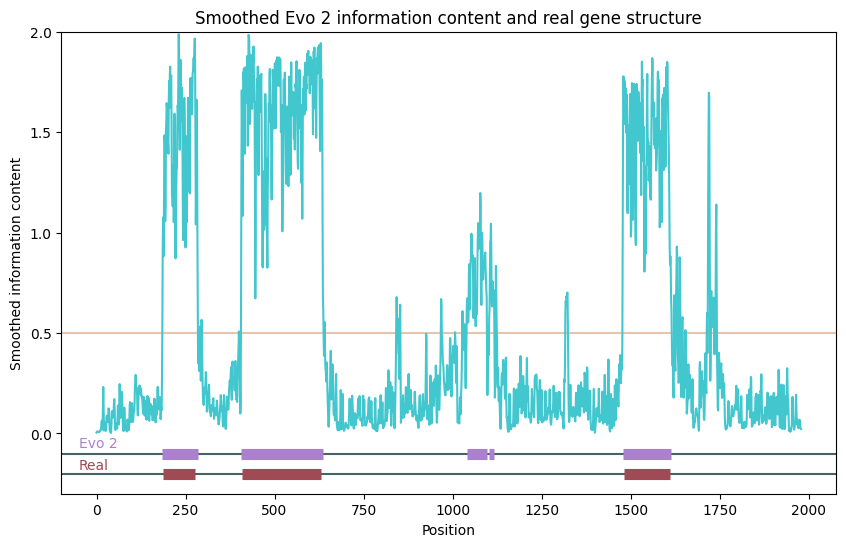

In [27]:
draw_llm_vs_real(evo2_probs, real_exons, model_name="Evo 2")

In [28]:
evo1_tensors = safe_open("tensors/roderic_seq.safetensors", "pt")

In [29]:
evo1_probs = evo1_tensors.get_tensor("probs")

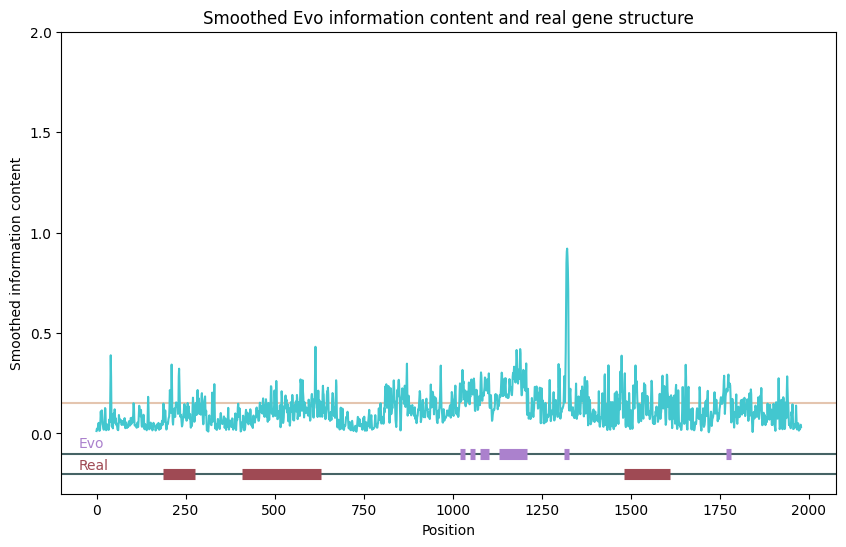

In [30]:
draw_llm_vs_real(evo1_probs, real_exons, cutoff=0.15, model_name="Evo")

In [ ]:
print("##gff-version 3")
for exon in evo2_exons:
    print(f"mystery_seq\tevo2\texon\t{exon[0]}\t{exon[1]}\t50\t.\t.\t.")